In [29]:
import numpy as np
import pandas as pd
import mlflow
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer




# PreProcessing

In [30]:
df = pd.read_json("dataset.json", orient="split")
df = df.dropna()
df

,ANM,Non-ANM,Total,Direction,Lead_hours,Source_time,Speed
2020-10-09 15:00:00,4.482000,5.238,9.720000,NW,1.0,2020-10-09 12:00:00,5.81152
2020-10-09 18:00:00,5.227999,9.005,14.232999,NW,1.0,2020-10-09 15:00:00,5.81152
2020-10-09 21:00:00,2.253000,3.750,6.003000,WNW,1.0,2020-10-09 18:00:00,4.91744
2020-10-10 00:00:00,2.091000,1.893,3.984000,WNW,1.0,2020-10-09 21:00:00,5.81152
2020-10-10 03:00:00,0.142000,1.476,1.618000,NNW,1.0,2020-10-10 00:00:00,3.12928
...,...,...,...,...,...,...,...
2021-04-07 00:00:00,14.335996,18.732,33.067996,NNW,1.0,2021-04-06 21:00:00,15.19936
2021-04-07 03:00:00,14.459997,18.437,32.896997,N,1.0,2021-04-07 00:00:00,13.85824
2021-04-07 06:00:00,13.791000,18.058,31.849000,NNW,1.0,2021-04-07 03:00:00,13.85824
2021-04-07 09:00:00,11.447002,14.395,25.842002,NW,1.0,2021-04-07 06:00:00,8.04672


In [31]:
cols = df.columns
for i in cols:
    print(i)
    print(df[i].value_counts())
    print()

ANM
 11.410001    7
 11.410002    6
 2.551999     5
 11.410000    4
 3.572000     2
             ..
 14.721000    1
-2.096000     1
 2.425000     1
 0.800000     1
-0.125000     1
Name: ANM, Length: 1277, dtype: int64

Non-ANM
21.465    2
18.731    2
19.977    2
17.743    2
19.685    2
         ..
22.715    1
19.570    1
20.141    1
19.873    1
3.750     1
Name: Non-ANM, Length: 1280, dtype: int64

Total
 7.738000     2
 4.978000     2
 3.800000     2
 5.617000     2
 7.529000     2
             ..
 33.731003    1
 12.624001    1
 31.888002    1
 11.446001    1
-1.250000     1
Name: Total, Length: 1313, dtype: int64

Direction
SSE    138
S      136
WSW    102
NNW    100
N       95
SW      93
W       91
SSW     91
NE      73
WNW     64
SE      61
ESE     60
NW      59
NNE     58
ENE     51
E       46
Name: Direction, dtype: int64

Lead_hours
1.0    1318
Name: Lead_hours, dtype: int64

Source_time
2021-02-06 16:00:00    1
2021-03-22 19:00:00    1
2020-10-20 18:00:00    1
2021-03-04 10:00

# Custom Transformers

In [32]:
class ClassEncoder_Custom_Class(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None): # Same function as earliere | OneHotEncoder_Custom
        category_dict = {}
        j = X["Direction"][0]
        category_dict[j] = 0
        counter = -1
    
        for i in X["Direction"]:
            counter += 1
            if i not in category_dict:
                category_dict[i] = category_dict[j]+1
                j = i
            X["Direction"][counter] = category_dict[i]
        return X
    
    
class TimeStamp_Converter(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        day = []
        month = []
        year = []
        hour = []
        column = X["Source_time"]
        for i in range(len(column)):
            temp = str(column[i]).split(" ")
            date = temp[0].split("-")
            year.append(date[0])
            month.append(date[1])
            day.append(date[2])
            
            hour = temp[1].split(":")
            hour.append(hour[0])
        
        X["Year"] = year
        X["Month"] = month
        X["Day"] = day
        X["Hour"] = hour
        
        X = X.drop(["Source_time"], axis=1)
        
        return X


# MLFlow

In [8]:
mlflow.sklearn.autolog()

poly_params = {
    "Poly__degree": range(1,8),
}

with mlflow.start_run():
    
    model = Pipeline([
        ("Column Transformer", ColumnTransformer([
            ("Date and Time", TimeStamp_Converter(),["Source_time"]),
            ("Encoder", ClassEncoder_Custom_Class(),["Direction"])], remainder="passthrough")),
        ("Poly", PolynomialFeatures()),
        ("LinReg", LinearRegression())
    ])

    gridsearch = GridSearchCV(model, poly_params, scoring = "r2")
    gridsearch.fit(X,y)
    

2022/05/09 22:06:51 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('Column Transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Encoder',
                                                  ClassEncoder_Custom_Class(),
        ...`
C:\Users\Jespe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Jespe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jespe\anaconda3\lib\site-packages\mlflow\utils\autologging_utils\safety.py", line 548, in safe_patch_function
    patch_function(call_original, *args, **kwargs)
  File "C:\Users\Jespe\anaconda3\lib\site-pa

C:\Users\Jespe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Jespe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jespe\anaconda3\lib\site-packages\mlflow\utils\autologging_utils\safety.py", line 435, in safe_patch_function
    return original(*args, **kwargs)
  File "C:\Users\Jespe\anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Jespe\anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\Jespe\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  Fi

C:\Users\Jespe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Jespe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jespe\anaconda3\lib\site-packages\mlflow\utils\autologging_utils\safety.py", line 435, in safe_patch_function
    return original(*args, **kwargs)
  File "C:\Users\Jespe\anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Jespe\anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\Jespe\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  Fi

C:\Users\Jespe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Jespe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jespe\anaconda3\lib\site-packages\mlflow\utils\autologging_utils\safety.py", line 435, in safe_patch_function
    return original(*args, **kwargs)
  File "C:\Users\Jespe\anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Jespe\anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\Jespe\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  Fi

C:\Users\Jespe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Jespe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jespe\anaconda3\lib\site-packages\mlflow\utils\autologging_utils\safety.py", line 435, in safe_patch_function
    return original(*args, **kwargs)
  File "C:\Users\Jespe\anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Jespe\anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\Jespe\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  Fi

C:\Users\Jespe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Jespe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jespe\anaconda3\lib\site-packages\mlflow\utils\autologging_utils\safety.py", line 435, in safe_patch_function
    return original(*args, **kwargs)
  File "C:\Users\Jespe\anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Jespe\anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\Jespe\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  Fi

AttributeError: 'numpy.ndarray' object has no attribute 'drop'

In [33]:
y = df["Total"]
X = df.drop(["Total","Lead_hours"], axis=1)


test = df.dropna(axis="columns", how ="any")
test

,ANM,Non-ANM,Total,Direction,Lead_hours,Source_time,Speed
2020-10-09 15:00:00,4.482000,5.238,9.720000,NW,1.0,2020-10-09 12:00:00,5.81152
2020-10-09 18:00:00,5.227999,9.005,14.232999,NW,1.0,2020-10-09 15:00:00,5.81152
2020-10-09 21:00:00,2.253000,3.750,6.003000,WNW,1.0,2020-10-09 18:00:00,4.91744
2020-10-10 00:00:00,2.091000,1.893,3.984000,WNW,1.0,2020-10-09 21:00:00,5.81152
2020-10-10 03:00:00,0.142000,1.476,1.618000,NNW,1.0,2020-10-10 00:00:00,3.12928
...,...,...,...,...,...,...,...
2021-04-07 00:00:00,14.335996,18.732,33.067996,NNW,1.0,2021-04-06 21:00:00,15.19936
2021-04-07 03:00:00,14.459997,18.437,32.896997,N,1.0,2021-04-07 00:00:00,13.85824
2021-04-07 06:00:00,13.791000,18.058,31.849000,NNW,1.0,2021-04-07 03:00:00,13.85824
2021-04-07 09:00:00,11.447002,14.395,25.842002,NW,1.0,2021-04-07 06:00:00,8.04672


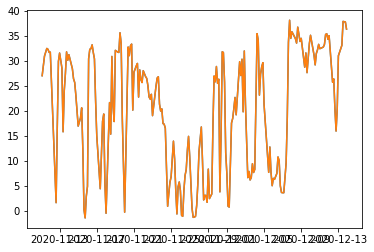

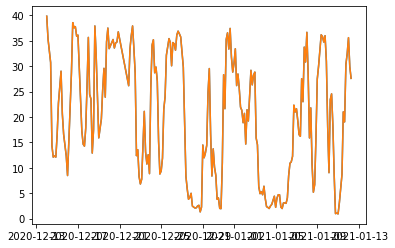

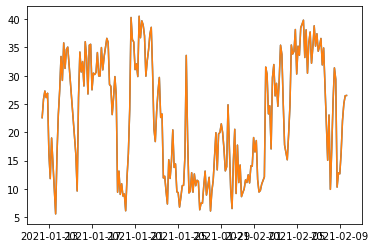

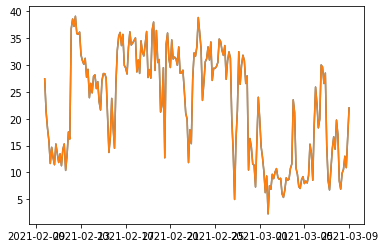

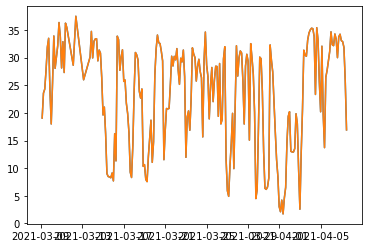

In [38]:
# TODO: Set the experiment name
mlflow.set_experiment("<Jete> - <Regression Experiment>")

poly_params = { # Poly features parameters
    "Poly__degree": range(1,8),
}

with mlflow.start_run(run_name="<ANM Features run>"):
    
    # TODO: Handle missing data

    pipeline = Pipeline([
        ("Poly", PolynomialFeatures()),
        ("LinReg", LinearRegression())
    ])

    # TODO: Currently the only metric is MAE. You should add more. What other metrics could you use? Why?
    metrics = [
        ("MAE", mean_absolute_error, []),
    ]

    X = df[["ANM","Non-ANM"]]
    y = df["Total"]

    number_of_splits = 5

    #TODO: Log your parameters. What parameters are important to log?
    #HINT: You can get access to the transformers in your pipeline using `pipeline.steps`
    for train, test in TimeSeriesSplit(number_of_splits).split(X,y):
        pipeline.fit(X.iloc[train],y.iloc[train])
        predictions = pipeline.predict(X.iloc[test])
        truth = y.iloc[test]

        plt.plot(truth.index, truth.values, label="Truth")
        plt.plot(truth.index, predictions, label="Predictions")
        plt.show()
        
        # Calculate and save the metrics for this fold
        for name, func, scores in metrics:
            score = func(truth, predictions)
            scores.append(score)
    
    # Log a summary of the metrics
    for name, _, scores in metrics:
            # NOTE: Here we just log the mean of the scores. 
            # Are there other summarizations that could be interesting?
            mean_score = sum(scores)/number_of_splits
            mlflow.log_metric(f"mean_{name}", mean_score)


In [ ]:
### EXPERIMENTS ###
# - Using more data and "ANM" and "Non-ANM" as features (High correlation)
# - Using less data but using "Wind Speed" and direction (Source_time???) as features
#     - Using Radian "Direction" encoding
# - Only using "Wind Speed"
# - 


In [ ]:
# TODO: Set the experiment name
mlflow.set_experiment("<ITU Username> - <Descriptive experiment name>")

with mlflow.start_run(run_name="<descriptive name>"):
    
    # TODO: Handle missing data

    pipeline = Pipeline([
        # TODO: You can start with your pipeline from assignment 1
    ])

    # TODO: Currently the only metric is MAE. You should add more. What other metrics could you use? Why?
    metrics = [
        ("MAE", mean_absolute_error, []),
    ]

    X = df[["Speed","Direction"]]
    y = df["Total"]

    number_of_splits = 5

    #TODO: Log your parameters. What parameters are important to log?
    #HINT: You can get access to the transformers in your pipeline using `pipeline.steps`
    
    for train, test in TimeSeriesSplit(number_of_splits).split(X,y):
        pipeline.fit(X.iloc[train],y.iloc[train])
        predictions = pipeline.predict(X.iloc[test])
        truth = y.iloc[test]

        plt.plot(truth.index, truth.values, label="Truth")
        plt.plot(truth.index, predictions, label="Predictions")
        plt.show()
        
        # Calculate and save the metrics for this fold
        for name, func, scores in metrics:
            score = func(truth, predictions)
            scores.append(score)
    
    # Log a summary of the metrics
    for name, _, scores in metrics:
            # NOTE: Here we just log the mean of the scores. 
            # Are there other summarizations that could be interesting?
            mean_score = sum(scores)/number_of_splits
            mlflow.log_metric(f"mean_{name}", mean_score)
